# Titanic — Decision Tree

## Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 42

In [2]:
# read training data
df = pd.read_csv('train.csv')
print('shape:', df.shape)
df.head()

shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Simple preprocessing and feature engineering
data = df.copy()
# New feature: whether Cabin info exists
data['HasCabin'] = data['Cabin'].notna().astype(int)
# Fill missing Age with median, Fare with median, Embarked with mode
data['Age'] = data['Age'].fillna(data['Age'].median())
data['Fare'] = data['Fare'].fillna(data['Fare'].median())
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode()[0])
# New features: FamilySize and IsAlone
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)
# Drop unnecessary columns
data = data.drop(['PassengerId','Name','Ticket','Cabin'], axis=1)
# One-hot encode categorical variables (Sex, Embarked)
data = pd.get_dummies(data, columns=['Sex','Embarked'], drop_first=True)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,HasCabin,FamilySize,IsAlone,Sex_male,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,0,2,0,True,False,True
1,1,1,38.0,1,0,71.2833,1,2,0,False,False,False
2,1,3,26.0,0,0,7.9250,0,1,1,False,False,True
3,1,1,35.0,1,0,53.1000,1,2,0,False,False,True
4,0,3,35.0,0,0,8.0500,0,1,1,True,False,True


In [4]:
# Select features and split the dataset
features = ['Pclass','Age','SibSp','Parch','Fare','HasCabin','FamilySize','IsAlone','Sex_male','Embarked_Q','Embarked_S']
X = data[features]
y = data['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('train shape:', X_train.shape, 'val shape:', X_val.shape)

train shape: (712, 11) val shape: (179, 11)


## (Finetune)Implement Grid search and five fold cross validation

In [5]:
# Use GridSearchCV to tune Decision Tree hyperparameters
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth': [2,3,4,5,6,7,8,10, None],
    'min_samples_split': [2,4,5,6],
    'min_samples_leaf': [2,4,6]
}
DT_gird = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy', n_jobs=1)
DT_gird.fit(X_train, y_train)
# Display best parameters and mean CV score
print("Best Parameters:", DT_gird.best_params_)
print("Best Mean CV Accuracy:", DT_gird.best_score_)

# ---- Show all 5 fold accuracies for the best model ----
print("\nIndividual fold accuracies:")
cv_results = DT_gird.cv_results_
best_index = DT_gird.best_index_
DT_split_scores = [cv_results[f'split{i}_test_score'][best_index] for i in range(5)]

for i, score in enumerate(DT_split_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nAverage CV Accuracy: {np.mean(DT_split_scores)*100:.2f}%")


Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 6, 'min_samples_split': 2}
Best Mean CV Accuracy: 0.8216881709839458

Individual fold accuracies:
Fold 1: 0.8322
Fold 2: 0.7692
Fold 3: 0.8239
Fold 4: 0.8239
Fold 5: 0.8592

Average CV Accuracy: 82.17%


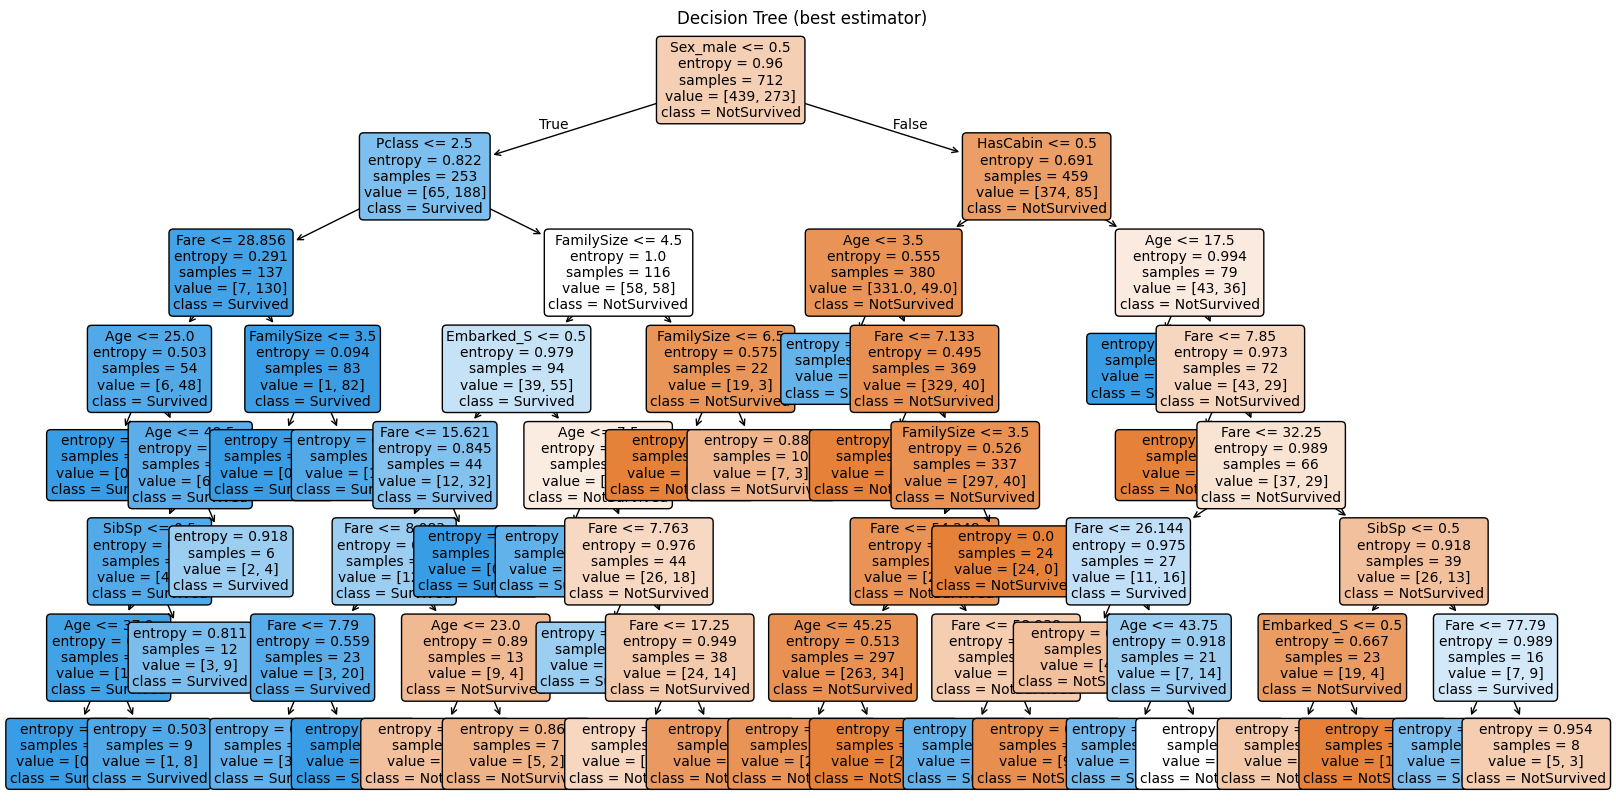

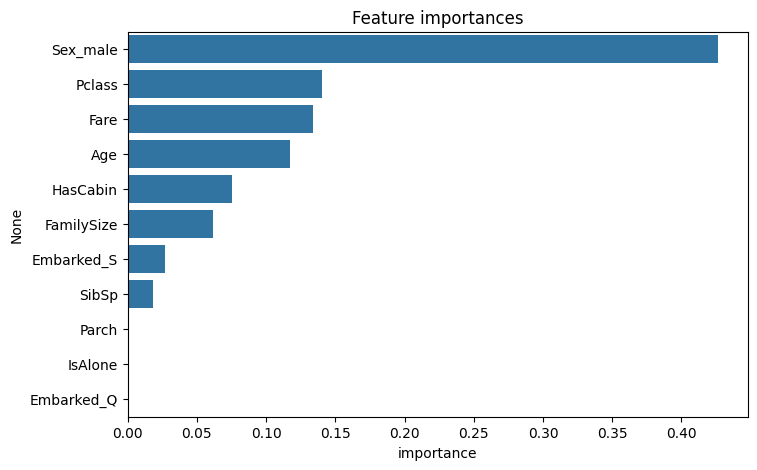

Sex_male      0.426551
Pclass        0.140200
Fare          0.133546
Age           0.117207
HasCabin      0.075396
FamilySize    0.061856
Embarked_S    0.026879
SibSp         0.018365
Parch         0.000000
IsAlone       0.000000
Embarked_Q    0.000000
dtype: float64

In [6]:
best = DT_gird.best_estimator_

plt.figure(figsize=(20,10))
plot_tree(best, feature_names=features, class_names=['NotSurvived','Survived'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree (best estimator)')
plt.show()


fi = pd.Series(best.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=fi.values, y=fi.index)
plt.title('Feature importances')
plt.xlabel('importance')
plt.show()
fi

## Random Forest

In [7]:
# Random Forest: GridSearchCV and evaluation
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None,5,7,10],
    'min_samples_split': [2,5,6,8],
    'min_samples_leaf': [2,3]
}

rf_grid = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy', n_jobs=1)
rf_grid.fit(X_train, y_train)
# Display best parameters and mean CV score
print("Best Parameters:", rf_grid.best_params_)
print("Best Mean CV Accuracy:", rf_grid.best_score_)

# ---- Show all 5 fold accuracies for the best model ----
print("\nIndividual fold accuracies:")
cv_results = rf_grid.cv_results_
best_index = rf_grid.best_index_
rf_split_scores = [cv_results[f'split{i}_test_score'][best_index] for i in range(5)]

for i, score in enumerate(rf_split_scores, 1):
    print(f"Fold {i}: {score:.4f}")

print(f"\nAverage CV Accuracy: {np.mean(rf_split_scores)*100:.2f}%")


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100}
Best Mean CV Accuracy: 0.8301388752092975

Individual fold accuracies:
Fold 1: 0.7972
Fold 2: 0.8042
Fold 3: 0.8380
Fold 4: 0.8451
Fold 5: 0.8662

Average CV Accuracy: 83.01%


## Q5: Which algorithm is better, Decision Tree or Random Forest? What are your observations and conclusions from the algorithm comparison and analysis? 

A: 
From the 5-fold cross-validation results:
- Decision Tree average accuracy: 82.17%
- Random Forest average accuracy: 83.01%

The Random Forest algorithm performs slightly better than the Decision Tree. This improvement is expected because Random Forest is an ensemble method that builds multiple decision trees and combines their outputs to reduce overfitting and improve generalization.

While the Decision Tree is simpler and easier to interpret, it is more prone to overfitting on the training data, especially when the tree depth increases. In contrast, Random Forest mitigates this by averaging predictions from multiple trees, leading to better stability and higher accuracy across folds.

In conclusion, Random Forest model shows better overall performance and generalization capability compared to the single Decision Tree. Therefore, the Random Forest is the preferred model for this task due to its higher accuracy and robustness against overfitting.